In [24]:
import pickle
import torch
import graph_tool as gt
import graph_tool.topology as top
import networkx as nx
from graph_tool import Graph
# from graph_tool.topology import remove_self_loops, remove_parallel_edges


def get_rings(edge_index, max_k=7):
    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.numpy()

    edge_list = edge_index.T
    graph_gt = gt.Graph(directed=False)
    graph_gt.add_edge_list(edge_list)
    
    gt.generation.remove_self_loops(graph_gt) 
    gt.generation.remove_parallel_edges(graph_gt)

    
    # We represent rings with their original node ordering
    # so that we can easily read out the boundaries
    # The use of the `sorted_rings` set allows to discard
    # different isomorphisms which are however associated
    # to the same original ring – this happens due to the intrinsic
    # symmetries of cycles
    rings = set()
    sorted_rings = set()
    for k in range(3, max_k+1):
        pattern = nx.cycle_graph(k)
        pattern_edge_list = list(pattern.edges)
        pattern_gt = gt.Graph(directed=False)
        pattern_gt.add_edge_list(pattern_edge_list)
        sub_isos = top.subgraph_isomorphism(pattern_gt, graph_gt, induced=True, subgraph=True,
                                           generator=True)
        sub_iso_sets = map(lambda isomorphism: tuple(isomorphism.a), sub_isos)
        for iso in sub_iso_sets:
            if tuple(sorted(iso)) not in sorted_rings:
                rings.add(iso)
                sorted_rings.add(tuple(sorted(iso)))
    rings = list(rings)
    return rings

In [16]:
# load zinc250k dataset
with open('data/zinc250k_test_nx.pkl', 'rb') as f:
    zinc = pickle.load(f)

G = zinc[0]

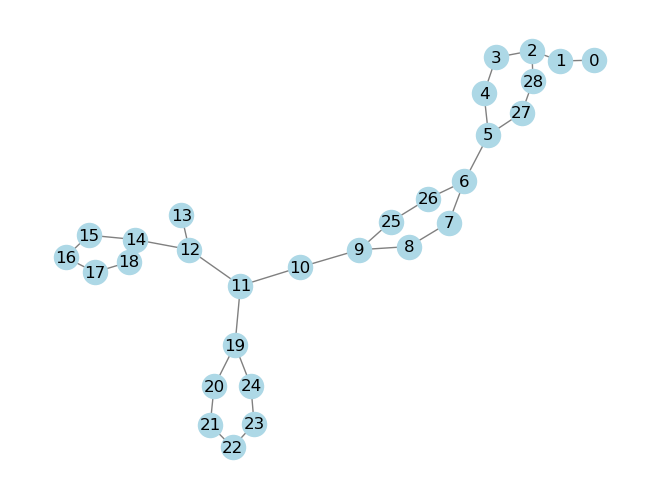

In [17]:
nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray")

In [18]:
def graph_to_edge_index(G):
    # Get edges
    edges = list(G.edges())

    # Convert to tensor format
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return edge_index


In [19]:
G_edge_index = graph_to_edge_index(G)
print(G_edge_index)

tensor([[ 0,  1,  2,  2,  3,  4,  5,  5,  6,  6,  7,  8,  9,  9, 10, 11, 11, 12,
         12, 14, 14, 15, 16, 17, 19, 19, 20, 21, 22, 23, 25, 27],
        [ 1,  2,  3, 28,  4,  5,  6, 27,  7, 26,  8,  9, 10, 25, 11, 12, 19, 13,
         14, 15, 18, 16, 17, 18, 20, 24, 21, 22, 23, 24, 26, 28]])


In [25]:
get_rings(G_edge_index)

[(6, 7, 8, 9, 25, 26),
 (2, 3, 4, 5, 27, 28),
 (19, 20, 21, 22, 23, 24),
 (14, 15, 16, 17, 18)]

## Create 2-cells list for every molecule

In [26]:
zinc_rings = []

# iterate zinc
for graph in zinc:
    edge_index = graph_to_edge_index(graph)
    rings = get_rings(edge_index)
    zinc_rings.append(rings)

# store in pickle
with open('data/zinc250k_test_rings.pkl', 'wb') as f:
    pickle.dump(zinc_rings, f)

In [33]:
zinc_rings[5]

[(14, 15, 16, 17, 19), (2, 3, 4, 6, 7, 8)]

In [27]:
# load qm9 dataset
with open('data/qm9_test_nx.pkl', 'rb') as f:
    qm9 = pickle.load(f)

qm9_rings = []

# iterate qm9
for graph in qm9:
    edge_index = graph_to_edge_index(graph)
    rings = get_rings(edge_index)
    qm9_rings.append(rings)

# store in pickle
with open('data/qm9_test_rings.pkl', 'wb') as f:
    pickle.dump(qm9_rings, f)
